# Importación de librerías

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import DataLoader, Dataset

import config
from discriminator_model import Discriminator
from generator_model import Generator
from train import train_fn

# Definición del dataset

In [14]:
class Content2OPaintingDataset(Dataset):
    def __init__(self, content_dir, painting_dir, is_test=False, transform=True):
        self.transform = transform
        self.content_data = os.listdir(content_dir)
        self.paintings_data = os.listdir(painting_dir)
        self.content_dir = content_dir
        self.painting_dir = painting_dir
        self.is_test = is_test

    def read_image(self, class_name, idx):
        images_classes = {
            'content': (self.content_data, self.content_dir),
            'painting': (self.paintings_data, self.painting_dir)
        }
        
        files_class, images_dir = images_classes.get(class_name)
        image_name = files_class[idx]
        image_path = os.path.join(images_dir, image_name)
        
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = config.IMG_TRANSFORMS(image) if not self.is_test else config.TEST_TRANSFORMS(image)
        
        return image
    
    def __len__(self):
        return min(len(self.content_data), len(self.paintings_data))

    def __getitem__(self, index):
        photo_img = self.read_image('content', index)
        painting_img = self.read_image('painting', index)
        
        return photo_img, painting_img

# Inicialización de los modelos

In [15]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.xavier_normal_(m.weight)

In [25]:
# Initialize discriminator models
content_distriminator = Discriminator().to(config.DEVICE)
painting_discriminator = Discriminator().to(config.DEVICE)

content_distriminator.apply(weights_init)
painting_discriminator.apply(weights_init)

# Initialize generator models
content_generator = Generator(img_channels=3, num_residuals=9).to(config.DEVICE)
painting_generator = Generator(img_channels=3, num_residuals=9).to(config.DEVICE)

content_generator.apply(weights_init)
painting_generator.apply(weights_init)

Generator(
  (encoder_blocks): ModuleList(
    (0): ConvBlock(
      (conv_block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (activation): Identity()
    )
    (1): ConvBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (activation): ReLU()
    )
    (2): ConvBlock(
      (conv_block): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (activation): ReLU()
    )
  )
  (bottleneck): Sequential(
    (0): ResidualBlock(
      (block): Sequential(
        (0): ConvBlock(
          (conv_block): Sequential(
           

# Initialización de los DataLoaders

In [26]:
train_dataset = Content2OPaintingDataset(
    content_dir=config.TRAIN_CONTENT_IMAGES_DIR,
    painting_dir=config.TRAIN_PAINTINGS_IMAGES_DIR,
    is_test=False
)

test_dataset = Content2OPaintingDataset(
    content_dir=config.TEST_CONTENT_IMAGES_DIR,
    painting_dir=config.TEST_PAINTINGS_IMAGES_DIR,
    is_test=True
)

data_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=True
)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=True
)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 5267
Test dataset size: 500


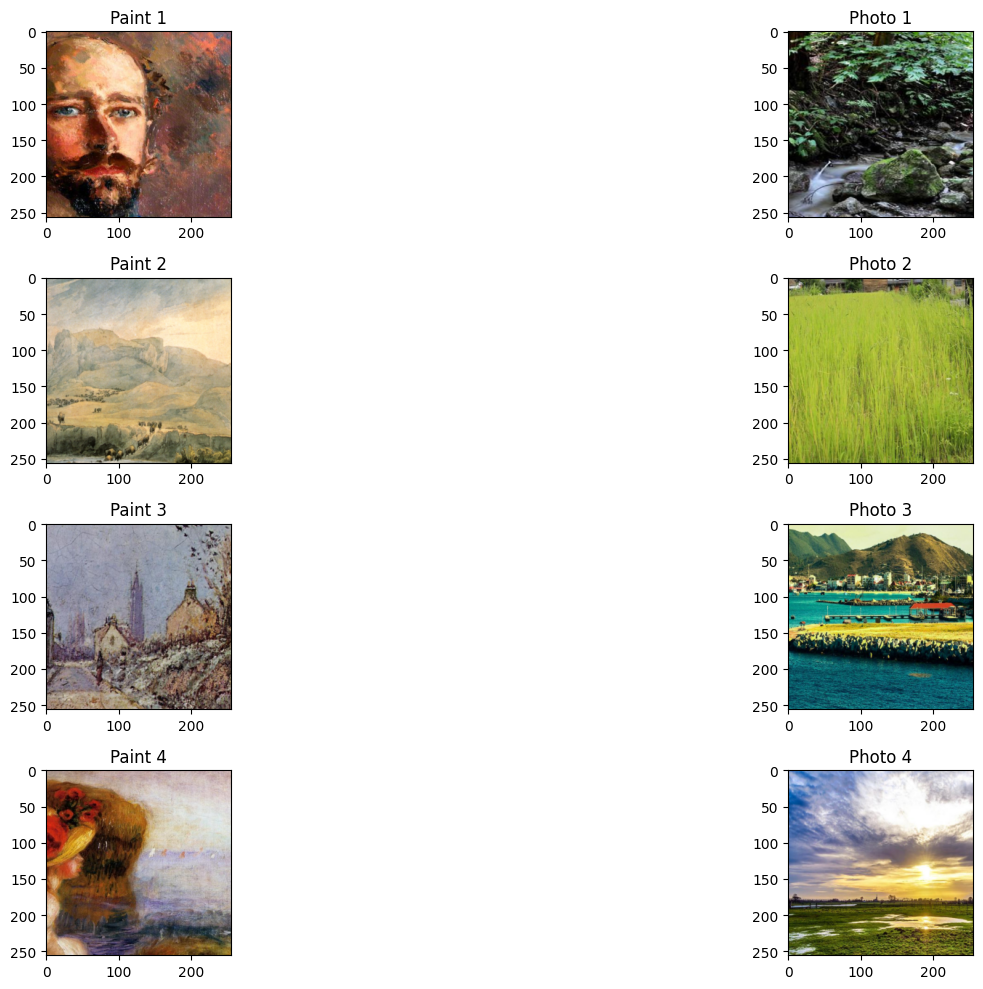

In [30]:
# Plot some photos from loader
plt.figure(figsize=(20, 10))

for i, (photo, paint) in enumerate(data_loader):
    if i == 4:
        break

    paint = paint * 0.5 + 0.5
    photo = photo * 0.5 + 0.5

    # Show paint image
    plt.subplot(4, 2, 2*i + 1)
    plt.title(f"Paint {i+1}")
    plt.imshow(paint[0].permute(1, 2, 0).cpu().numpy())

    # Show photo image
    plt.subplot(4, 2, 2*i + 2)
    plt.title(f"Photo {i+1}")
    plt.imshow(photo[0].permute(1, 2, 0).cpu().numpy())

plt.tight_layout()
plt.show()


# Entrenamiento de la red CycleGAN

In [31]:
os.makedirs("data/training_results", exist_ok=True)
os.makedirs("data/training_results/results", exist_ok=True)
os.makedirs("data/training_results/losses", exist_ok=True)

In [ ]:
train_fn(
    content_distriminator,
    painting_discriminator,
    content_generator,
    painting_generator,
    data_loader
)

In [9]:
import torchvision.transforms as transforms

def load_image(image_path, img_size=256):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)  # Add batch dimension

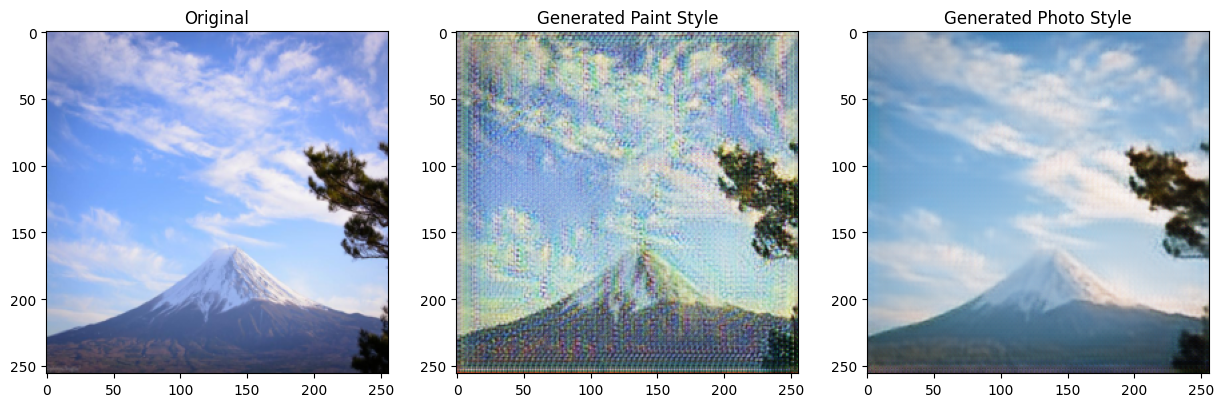

In [10]:
import matplotlib.pyplot as plt

image_path = "data/oil_painting/testA/00000292_(6).jpg"
image_tensor = load_image(image_path).to(config.DEVICE)

with torch.no_grad():
    fake_paint_image = painting_generator(image_tensor)
    fake_photo_image = content_generator(image_tensor)
    fake_paint_image = fake_paint_image * 0.5 + 0.5  # Rescale the output to [0, 1]
    fake_photo_image = fake_photo_image * 0.5 + 0.5  # Rescale the output to [0, 1]

# Show images
plt.figure(figsize=(15, 5))

# Show original image
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(image_tensor[0].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)  # Rescale to [0, 1]

# Show generated paint style image
plt.subplot(1, 3, 2)
plt.title("Generated Paint Style")
plt.imshow(fake_paint_image[0].permute(1, 2, 0).cpu().numpy())

# Show generated photo style image
plt.subplot(1, 3, 3)
plt.title("Generated Photo Style")
plt.imshow(fake_photo_image[0].permute(1, 2, 0).cpu().numpy())

plt.show()

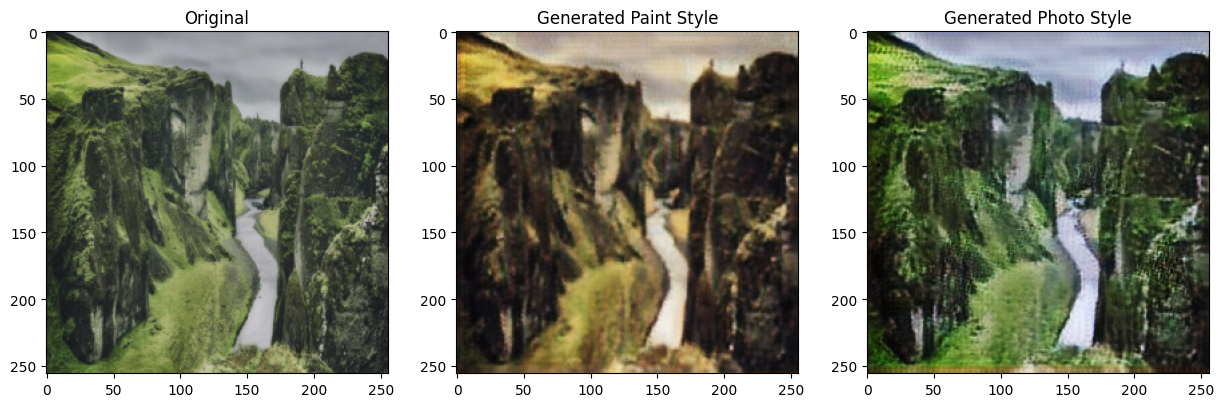

In [11]:
import matplotlib.pyplot as plt

image_path = "data/oil_painting/testA/00000327_(5).jpg"
image_tensor = load_image(image_path).to(config.DEVICE)

with torch.no_grad():
    fake_paint_image = painting_generator(image_tensor)
    fake_photo_image = content_generator(image_tensor)
    fake_paint_image = fake_paint_image * 0.5 + 0.5  # Rescale the output to [0, 1]
    fake_photo_image = fake_photo_image * 0.5 + 0.5  # Rescale the output to [0, 1]

# Show images
plt.figure(figsize=(15, 5))

# Show original image
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(image_tensor[0].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)  # Rescale to [0, 1]

# Show generated paint style image
plt.subplot(1, 3, 2)
plt.title("Generated Paint Style")
plt.imshow(fake_paint_image[0].permute(1, 2, 0).cpu().numpy())

# Show generated photo style image
plt.subplot(1, 3, 3)
plt.title("Generated Photo Style")
plt.imshow(fake_photo_image[0].permute(1, 2, 0).cpu().numpy())

plt.show()

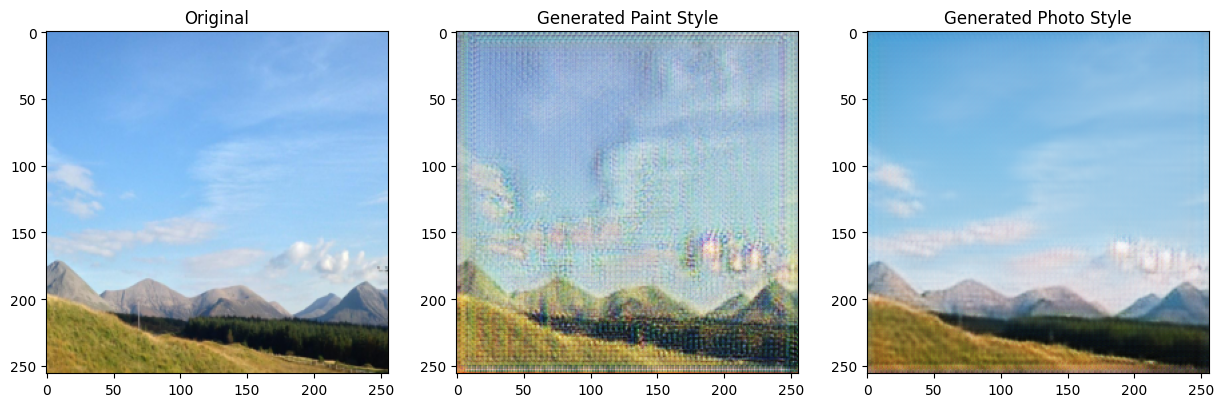

In [12]:
import matplotlib.pyplot as plt

image_path = "data/oil_painting/testA/00000292_(5).jpg"
image_tensor = load_image(image_path).to(config.DEVICE)

with torch.no_grad():
    fake_paint_image = painting_generator(image_tensor)
    fake_photo_image = content_generator(image_tensor)
    fake_paint_image = fake_paint_image * 0.5 + 0.5  # Rescale the output to [0, 1]
    fake_photo_image = fake_photo_image * 0.5 + 0.5  # Rescale the output to [0, 1]

# Show images
plt.figure(figsize=(15, 5))

# Show original image
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(image_tensor[0].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)  # Rescale to [0, 1]

# Show generated paint style image
plt.subplot(1, 3, 2)
plt.title("Generated Paint Style")
plt.imshow(fake_paint_image[0].permute(1, 2, 0).cpu().numpy())

# Show generated photo style image
plt.subplot(1, 3, 3)
plt.title("Generated Photo Style")
plt.imshow(fake_photo_image[0].permute(1, 2, 0).cpu().numpy())

plt.show()

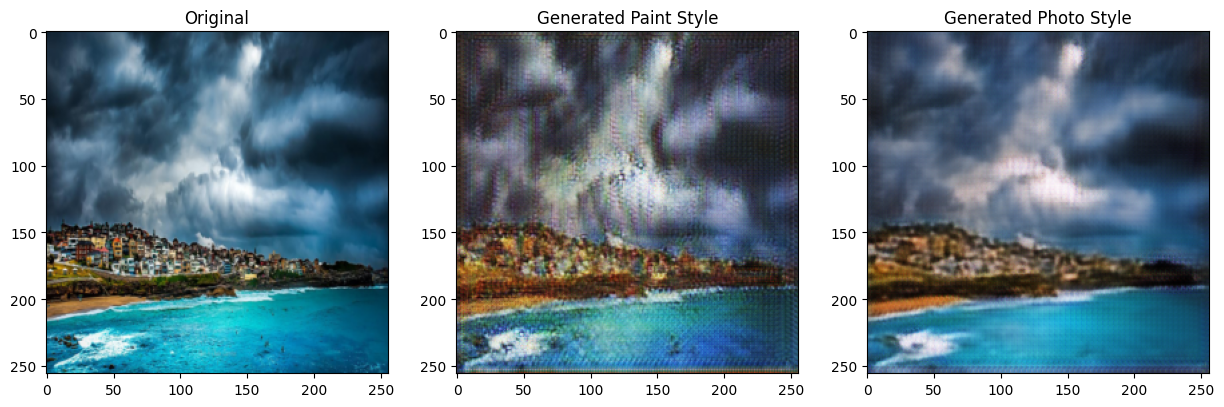

In [13]:
image_path = "data/oil_painting/testA/00000292_(4).jpg"
image_tensor = load_image(image_path).to(config.DEVICE)

with torch.no_grad():
    fake_paint_image = painting_generator(image_tensor)
    fake_photo_image = content_generator(image_tensor)
    fake_paint_image = fake_paint_image * 0.5 + 0.5  # Rescale the output to [0, 1]
    fake_photo_image = fake_photo_image * 0.5 + 0.5  # Rescale the output to [0, 1]

# Show images
plt.figure(figsize=(15, 5))

# Show original image
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(image_tensor[0].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)  # Rescale to [0, 1]

# Show generated paint style image
plt.subplot(1, 3, 2)
plt.title("Generated Paint Style")
plt.imshow(fake_paint_image[0].permute(1, 2, 0).cpu().numpy())

# Show generated photo style image
plt.subplot(1, 3, 3)
plt.title("Generated Photo Style")
plt.imshow(fake_photo_image[0].permute(1, 2, 0).cpu().numpy())

plt.show()

In [14]:
from skimage.metrics import structural_similarity as ssim
import numpy as np
from PIL import Image

# Function to convert tensors to numpy arrays for SSIM calculation
def tensor_to_numpy(image_tensor):
    image_np = image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()  # Convert to HWC format
    image_np = (image_np * 255).astype(np.uint8)  # Rescale to [0, 255] for SSIM calculation
    return image_np

# Convert images to numpy format
original_image_np = tensor_to_numpy(image_tensor)
fake_paint_image_np = tensor_to_numpy(fake_paint_image)
fake_photo_image_np = tensor_to_numpy(fake_photo_image)

# Specify a smaller win_size if images are smaller than 7x7 pixels
win_size = 3  # Adjust this value if your images are larger but still encounter issues

# Compute SSIM between the original content image and the generated painting style image
ssim_paint = ssim(original_image_np, fake_paint_image_np, win_size=win_size, multichannel=True)
print(f"SSIM between original and generated paint style: {ssim_paint}")

# Compute SSIM between the original content image and the generated photo style image
ssim_photo = ssim(original_image_np, fake_photo_image_np, win_size=win_size, multichannel=True)
print(f"SSIM between original and generated photo style: {ssim_photo}")

SSIM between original and generated paint style: 0.1756508337024937
SSIM between original and generated photo style: 0.28421725307123563
